In [1]:
library(SingleCellExperiment)
library(dplyr)
library(ggplot2)
library(multinichenetr)
library(R.utils)
library(data.table) #to read gz file
library(Seurat)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [2]:
input_dir <- "../../../../../results/data_preprocessing/Lasry/preprocessed/"
db_dir <- "../../../../../results/method_comparison/build_customDB/NicheNet/"
output_dir <- "../../../../../results/method_comparison/compare_algorithms/NicheNet/"

In [3]:
# # load counts
# print("load counts")
# counts <- read.table(gzfile(paste0(path_in,"/counts_corr.csv.gz")
#                             )
#                      ,sep = ","
#                      ,row.names = 1
#                      ,header = TRUE
#                      )
# # load counts

counts <- fread(paste0(input_dir,"counts_corr.csv.gz"), header = TRUE,check.names=FALSE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]
# head(str(counts))
# print(str(counts))

In [4]:
# load cell annotation
print("load cell annotation")
anno_cells <- read.table(paste0(input_dir,"anno_cells_corr.txt")
                         ,sep = "\t"
                         ,row.names = 1
                         ,header = TRUE
                         )
# print(str(anno_cells))

[1] "load cell annotation"


In [5]:
srt=CreateSeuratObject(counts=counts, meta.data=anno_cells)

In [6]:
srt@meta.data$health_status %>% table()

.
    AML healthy 
  21311   25391 

In [7]:
srt@meta.data$cell_type %>% table()

.
    B    DC   Ery  Gran  HSPC  Mono    NK     T 
 4765  1634  1674  2332  3169 18004  3078 12046 

In [8]:
Idents(srt) <- "cell_type"

In [9]:
cell_type_list <- unique(srt@meta.data$cell_type)
sample_list <- unique(srt@meta.data$sample_ID)

In [10]:
organism = "human"
if(organism == "human"){
  lr_network = readRDS(paste0(db_dir,"lig_rec_sources.rds"))
  lr_network = lr_network %>% dplyr::rename(ligand = from, receptor = to) %>% distinct(ligand, receptor) %>% mutate(ligand = make.names(ligand), receptor = make.names(receptor))
  ligand_target_matrix = readRDS(paste0(db_dir,"ligand_target_matrixWithweights.rds"))
  colnames(ligand_target_matrix) = colnames(ligand_target_matrix) %>% make.names()
  rownames(ligand_target_matrix) = rownames(ligand_target_matrix) %>% make.names()
} else if(organism == "mouse"){
  lr_network = readRDS(url("https://zenodo.org/record/7074291/files/lr_network_mouse_21122021.rds"))
  lr_network = lr_network %>% dplyr::rename(ligand = from, receptor = to) %>% distinct(ligand, receptor) %>% mutate(ligand = make.names(ligand), receptor = make.names(receptor))
  ligand_target_matrix = readRDS(url("https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final_mouse.rds"))
  colnames(ligand_target_matrix) = colnames(ligand_target_matrix) %>% make.names()
  rownames(ligand_target_matrix) = rownames(ligand_target_matrix) %>% make.names()
}

In [11]:
sce = Seurat::as.SingleCellExperiment(srt, assay = "RNA")

In [12]:
sce = alias_to_symbol_SCE(sce, "human") %>% makenames_SCE()

[1] "there are provided symbols that are not in the alias annotation table: "
   [1] "AL627309.5"     "AL645608.2"     "AL162741.1"     "AL391244.2"    
   [5] "AL645728.1"     "AL691432.4"     "AL691432.2"     "FO704657.1"    
   [9] "AL590822.2"     "AL590822.3"     "AL513477.2"     "AL139246.5"    
  [13] "AL031848.2"     "AL139424.3"     "AL109811.2"     "AL109811.1"    
  [17] "AL021155.5"     "AL031283.1"     "AL450998.2"     "AL109627.1"    
  [21] "AL137802.2"     "BX284668.5"     "BX284668.6"     "AL031432.1"    
  [25] "AL031432.4"     "AL031432.3"     "AL031280.1"     "AL020996.1"    
  [29] "AL020997.2"     "AL353622.1"     "AL360012.1"     "AL451070.1"    
  [33] "AL136115.2"     "AL445248.1"     "AL049795.1"     "AC004865.2"    
  [37] "AL139286.3"     "AL591845.1"     "AL139260.1"     "AL356055.1"    
  [41] "AL033527.3"     "AL033527.4"     "AL050341.2"     "AL512353.1"    
  [45] "AL139289.2"     "AL357079.1"     "AL139220.2"     "AL592182.3"    
  [49] "AL050343.2"   

In [13]:
sample_id = "sample_ID"
group_id = "health_status"
celltype_id = "cell_type"
covariates = NA
batches = NA

In [14]:
senders_oi = SummarizedExperiment::colData(sce)[,celltype_id] %>% unique()
receivers_oi = SummarizedExperiment::colData(sce)[,celltype_id] %>% unique()

In [15]:
min_cells = 10

In [16]:
abundance_expression_info = get_abundance_expression_info(sce = sce, sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, min_cells = min_cells, senders_oi = senders_oi, receivers_oi = receivers_oi, lr_network = lr_network, batches = batches)

Warning message in edgeR::DGEList(pb@assays@data[[celltype_oi]]):
“library size of zero detected”
Warning message in edgeR::DGEList(pb@assays@data[[celltype_oi]]):
“library size of zero detected”
Warning message in edgeR::DGEList(pb@assays@data[[celltype_oi]]):
“library size of zero detected”


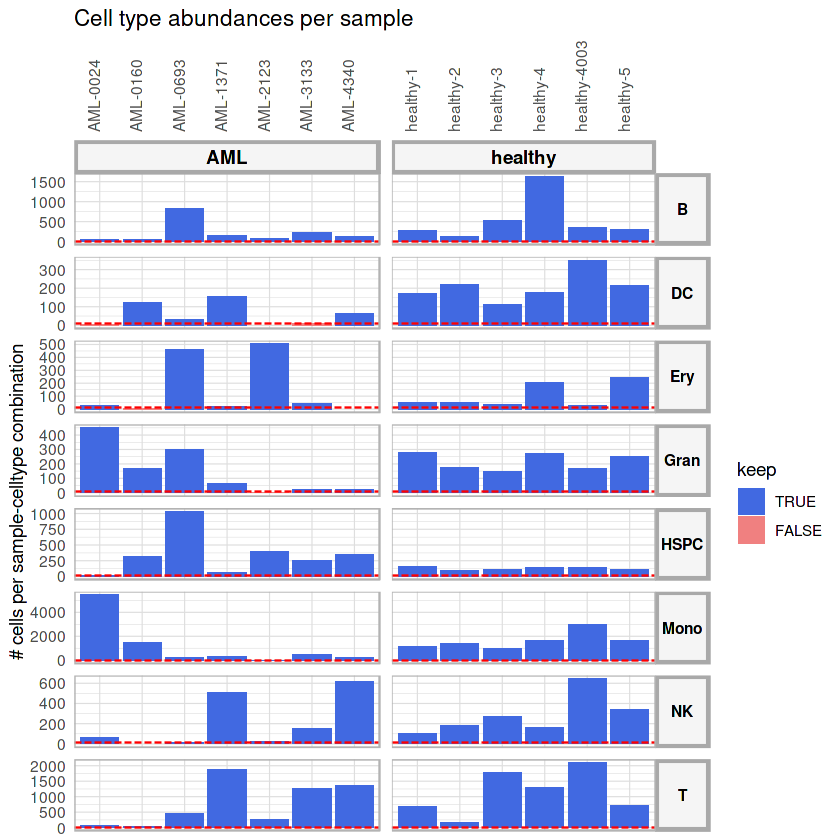

In [17]:
abundance_expression_info$abund_plot_sample

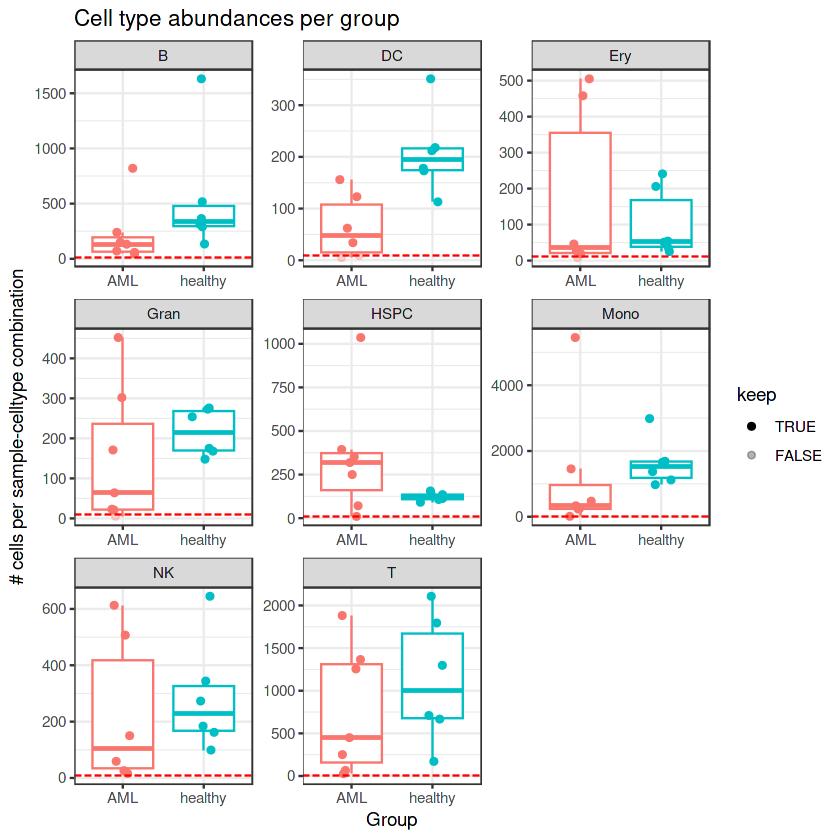

In [18]:
abundance_expression_info$abund_plot_group

In [19]:
?get_DE_info

In [20]:
contrasts_oi = c("'healthy-AML','AML-healthy'")
contrast_tbl = tibble(contrast = c("healthy-AML","AML-healthy"), group = c("healthy","AML"))

In [21]:
DE_info = get_DE_info(sce = sce, sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, batches = batches, covariates = covariates, contrasts_oi = contrasts_oi, min_cells = min_cells)

In [22]:
DE_info$celltype_de$de_output_tidy %>% arrange(p_adj) %>% head()

gene,cluster_id,logFC,logCPM,F,p_val,p_adj.loc,p_adj,contrast
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SERPINE2,HSPC,3.30,6.36,124,5.45e-10,4.13e-06,4.13e-06,healthy-AML
SERPINE2,HSPC,-3.30,6.36,124,5.45e-10,4.13e-06,4.13e-06,AML-healthy
E2F2,Ery,-3.07,7.04,126,2.73e-09,5.74e-06,5.74e-06,healthy-AML
AC002558.3,Ery,-1.71,7.91,118,4.42e-09,5.74e-06,5.74e-06,healthy-AML
OSBP2,Ery,-2.90,7.65,122,3.43e-09,5.74e-06,5.74e-06,healthy-AML
E2F2,Ery,3.07,7.04,126,2.73e-09,5.74e-06,5.74e-06,AML-healthy


In [23]:
celltype_de = DE_info$celltype_de$de_output_tidy

In [24]:
sender_receiver_de = combine_sender_receiver_de(
  sender_de = celltype_de,
  receiver_de = celltype_de,
  senders_oi = senders_oi,
  receivers_oi = receivers_oi,
  lr_network = lr_network
)

In [25]:
sender_receiver_de %>% head(20)

contrast,sender,receiver,ligand,receptor,lfc_ligand,lfc_receptor,ligand_receptor_lfc_avg,p_val_ligand,p_adj_ligand,p_val_receptor,p_adj_receptor
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AML-healthy,NK,Mono,CCL3L1,CCR5,2.530,3.01,2.7700,9.23e-04,2.67e-01,2.22e-06,6.97e-03
AML-healthy,Gran,Mono,CCL5,CCR5,2.290,3.01,2.6500,1.09e-03,1.25e-01,2.22e-06,6.97e-03
AML-healthy,T,Ery,THBS1,SLC7A5,1.710,3.35,2.5300,2.83e-02,3.79e-01,1.38e-07,2.81e-05
AML-healthy,T,Mono,CCL3L1,CCR5,2.050,3.01,2.5300,1.48e-03,2.55e-01,2.22e-06,6.97e-03
healthy-AML,Gran,DC,HP,CD163,3.040,1.96,2.5000,5.15e-04,9.83e-02,1.10e-02,3.93e-01
AML-healthy,Mono,Mono,CCL4,CCR5,1.900,3.01,2.4550,1.82e-02,3.80e-01,2.22e-06,6.97e-03
healthy-AML,HSPC,DC,SERPINE2,LRP1,3.300,1.45,2.3750,5.45e-10,4.13e-06,1.77e-03,2.17e-01
AML-healthy,Mono,Mono,CCL5,CCR5,1.630,3.01,2.3200,1.15e-02,3.19e-01,2.22e-06,6.97e-03
AML-healthy,Gran,Mono,CCL3L1,CCR5,1.450,3.01,2.2300,3.40e-02,3.80e-01,2.22e-06,6.97e-03


In [26]:
logFC_threshold = 1
p_val_threshold = 0.05
fraction_cutoff = 0.05

In [27]:
p_val_adj = TRUE

In [29]:
top_n_target = 250

In [30]:
verbose = TRUE
cores_system = 12
n.cores = min(cores_system, sender_receiver_de$receiver %>% unique() %>% length()) # use one core per receiver cell type

In [31]:
ligand_activities_targets_DEgenes = suppressMessages(suppressWarnings(get_ligand_activities_targets_DEgenes(
  receiver_de = celltype_de,
  receivers_oi = receivers_oi,
  ligand_target_matrix = ligand_target_matrix,
  logFC_threshold = logFC_threshold,
  p_val_threshold = p_val_threshold,
  p_val_adj = p_val_adj,
  top_n_target = top_n_target,
  verbose = verbose, 
  n.cores = n.cores
)))

ERROR: Error in unserialize(node$con): error reading from connection


In [35]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11399192,608.8,17459508,932.5,17459508,932.5
Vcells,927284748,7074.7,2378409284,18145.9,1895101237,14458.5


In [33]:
ligand_activities_targets_DEgenes = get_ligand_activities_targets_DEgenes(
  receiver_de = celltype_de,
  receivers_oi = receivers_oi,
  ligand_target_matrix = ligand_target_matrix,
  logFC_threshold = logFC_threshold,
  p_val_threshold = p_val_threshold,
  p_val_adj = p_val_adj,
  top_n_target = top_n_target,
  verbose = verbose, 
  n.cores = n.cores
)

In [34]:
ligand_activities_targets_DEgenes

ligand,activity,contrast,target,ligand_target_weight,receiver,direction_regulation,activity_scaled
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<fct>,<dbl>
A2M,-2.229227e-04,healthy-AML,NA,NA,B,up,-0.06203147
ACTR2,-3.021129e-04,healthy-AML,NA,NA,B,up,-0.26241893
ADAM11,-1.815976e-04,healthy-AML,NA,NA,B,up,0.04253994
ADCYAP1,3.051680e-04,healthy-AML,SMIM7,8.290071e-04,B,up,1.27428015
ADIPOQ,-4.666534e-04,healthy-AML,NA,NA,B,up,-0.67878177
ADM,-3.564917e-04,healthy-AML,NA,NA,B,up,-0.40002215
ADM2,-2.857167e-04,healthy-AML,NA,NA,B,up,-0.22092896
ADO,-1.040113e-04,healthy-AML,NA,NA,B,up,0.23886899
AFDN,-5.892398e-04,healthy-AML,NA,NA,B,up,-0.98898163


In [37]:
prioritizing_weights_DE = c("de_ligand" = 1,
                         "de_receptor" = 1)
prioritizing_weights_activity = c("activity_scaled" = 2)

prioritizing_weights_expression_specificity = c("exprs_ligand" = 2,
                         "exprs_receptor" = 2)

prioritizing_weights_expression_sufficiency = c("frac_exprs_ligand_receptor" = 1)

prioritizing_weights_relative_abundance = c( "abund_sender" = 0,
                         "abund_receiver" = 0)

In [38]:
prioritizing_weights = c(prioritizing_weights_DE, 
                         prioritizing_weights_activity, 
                         prioritizing_weights_expression_specificity,
                         prioritizing_weights_expression_sufficiency, 
                         prioritizing_weights_relative_abundance)

In [39]:
empirical_pval=FALSE

In [42]:
multinichenet_output = multi_nichenet_analysis(sce = sce, celltype_id = celltype_id, sample_id = sample_id, group_id = group_id, 
                                lr_network = lr_network, ligand_target_matrix = ligand_target_matrix, contrasts_oi = contrasts_oi, contrast_tbl = contrast_tbl, batches = batches, covariates = covariates,
                                prioritizing_weights = prioritizing_weights, min_cells = min_cells, logFC_threshold = logFC_threshold, p_val_threshold = p_val_threshold,  
                                fraction_cutoff = fraction_cutoff, p_val_adj = p_val_adj, empirical_pval = empirical_pval, top_n_target = top_n_target, n.cores = n.cores, sender_receiver_separate = FALSE, verbose = TRUE)
## [1] "Calculate differential expression for all cell types"
## [1] "Make diagnostic abundance plots + Calculate expression information"
## [1] "Calculate NicheNet ligand activities and ligand-target links"
## [1] "Combine all the information in prioritization tables"

[1] "Calculate differential expression for all cell types"
[1] "Make diagnostic abundance plots + Calculate expression information"


Warning message in edgeR::DGEList(pb@assays@data[[celltype_oi]]):
“library size of zero detected”
Warning message in edgeR::DGEList(pb@assays@data[[celltype_oi]]):
“library size of zero detected”
Warning message in edgeR::DGEList(pb@assays@data[[celltype_oi]]):
“library size of zero detected”


[1] "Calculate NicheNet ligand activities and ligand-target links"


ERROR: Error in unserialize(node$con): error reading from connection


In [ ]:
multinichenet_output = multi_nichenet_analysis(sce = sce, celltype_id = celltype_id, sample_id = sample_id, group_id = group_id, 
                                lr_network = lr_network, ligand_target_matrix = ligand_target_matrix, contrasts_oi = contrasts_oi, contrast_tbl = contrast_tbl, batches = batches, covariates = covariates,
                                prioritizing_weights = prioritizing_weights, min_cells = min_cells, logFC_threshold = logFC_threshold, p_val_threshold = p_val_threshold,  
                                fraction_cutoff = fraction_cutoff, p_val_adj = p_val_adj, empirical_pval = empirical_pval, top_n_target = top_n_target, n.cores = n.cores, sender_receiver_separate = FALSE, verbose = TRUE)
## [1] "Calculate differential expression for all cell types"
## [1] "Make diagnostic abundance plots + Calculate expression information"
## [1] "Calculate NicheNet ligand activities and ligand-target links"
## [1] "Combine all the information in prioritization tables"